In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
#Loading data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/My Drive/Set3"

Mounted at /content/drive


In [3]:
#Scales altitude to value above the runway height
class AltitudeScaler():
  def __init__(self):
    self.groundAlt = 0
  def fit(self, data):
    self.groundAlt = data[len(data)-1]
  def transform(self, data):
    arr = []
    for i in range(len(data)):
      arr.append((data[i]-self.groundAlt)/3000)

    return arr
  def untransform(self, data):
    arr = []
    for i in range(len(arr)):
      arr.append(3000*data[i] + groundAlt)
    return arr
  def fit_and_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [4]:
#Scales heading relative to runway heading
class HeadingScaler():
  def __init__(self):
    self.runwayHeading = 0
  def fix(self, n):
    if (n <= 180.0) and (n >= -180.0):
      return n
    elif (n > 180.0):
      return self.fix(n-360.0)
    elif (n < -180.0):
      return self.fix(n+360.0)
  def fit(self, headingData, windData):
    self.runwayHeading = headingData[len(headingData)-1]
  def transform(self, headingData, windData):
    arr = []
    for i in range(len(headingData)):
      difference = -(self.runwayHeading - headingData[i])

      difference = self.fix(difference)

      arr.append(difference/180.0)
    arr2 = []
    for i in range(len(windData)):
      difference = -(self.runwayHeading - windData[i])
      difference = self.fix(difference)
      arr2.append(difference/180.0)
    return arr, arr2
  def untransform(self, headingData, windData):
    arr = []
    for i in range(len(headingData)):
      difference = headingData[i] * 180.0
      arr.append(difference+self.runwayHeading)
    arr2 = []
    for i in range(len(windData)):
      difference = windData[i] * 180.0
      arr2.append(difference+self.runwayHeading)
    return arr, arr2
  def fit_and_transform(self, headingData, windData):
    self.fit(headingData, windData)
    return self.transform(headingData, windData)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

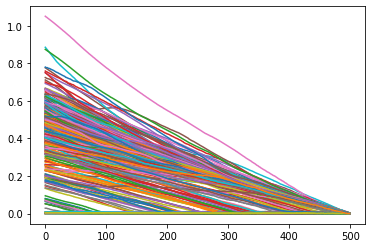

In [5]:
#Scaling Training Set
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = []
for i in range(982):
  df = pd.read_csv(f'/content/drive/My Drive/Landings/Train/Flight{i+1}.csv')
  print(i)
  altScaler = AltitudeScaler()
  altScaler.fit(df['altitude'])
  df['altitude'] = altScaler.transform(df['altitude'])
  headingScaler = HeadingScaler()
  headingScaler.fit(df['heading'],df['windDirection'])
  df['heading'],df['windDirection'] = headingScaler.transform(df['heading'],df['windDirection'])
  df['groundspeed'] = df['groundspeed'] / 250.0
  df['pitch'] = df['pitch'] / 90.0
  df['roll'] = df['roll'] / 90.0
  plt.plot(df['altitude'])
  data.append(df.values)
data = np.asarray(data)

In [18]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y[3:4])

    return np.array(xs), np.array(ys)

In [7]:
#Shaping Training Set
X = []
y = []
for t in range(982):
  xx , yy = create_sequences(list(data[:,:,:][t]),1)
  X.append(xx)
  y.append(yy)
X[2]

array([[[ 4.35333333e-01,  5.16500000e-01, -4.88267096e-03, ...,
          6.95780012e-02,  1.39453163e+01,  5.00447606e-01]],

       [[ 4.34333333e-01,  5.17000000e-01, -3.69862095e-02, ...,
          6.93643782e-02,  1.49414101e+01,  5.04353856e-01]],

       [[ 4.33666667e-01,  5.17000000e-01, -3.63758791e-02, ...,
          6.90592024e-02,  1.49414101e+01,  4.96541356e-01]],

       ...,

       [[ 2.33333333e-03,  4.64500000e-01, -4.51648122e-03, ...,
         -1.25117832e-03,  2.98828197e+00,  3.52010106e-01]],

       [[ 2.66666667e-03,  4.64500000e-01, -4.51648122e-03, ...,
         -9.46002536e-04,  2.98828197e+00,  4.69197606e-01]],

       [[ 1.33333333e-03,  4.63000000e-01, -4.63853034e-03, ...,
         -3.66210938e-04,  3.98437595e+00,  3.91072606e-01]]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218


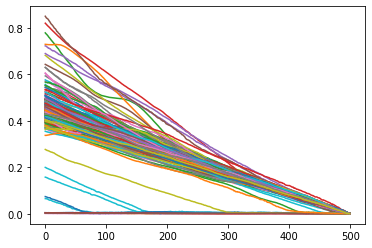

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

testData = []
for i in range(219):
  df = pd.read_csv(f'/content/drive/My Drive/Landings/Test/Flight{i+1}.csv')
  print(i)
  altScaler = AltitudeScaler()
  altScaler.fit(df['altitude'])
  df['altitude'] = altScaler.transform(df['altitude'])
  headingScaler = HeadingScaler()
  headingScaler.fit(df['heading'],df['windDirection'])
  df['heading'],df['windDirection'] = headingScaler.transform(df['heading'],df['windDirection'])
  df['groundspeed'] = df['groundspeed'] / 250.0
  df['pitch'] = df['pitch'] / 90.0
  df['roll'] = df['roll'] / 90.0
  plt.plot(df['altitude'])
  testData.append(df.values)
testData = np.asarray(testData)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

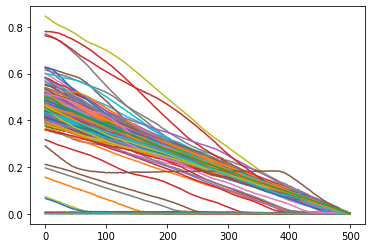

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

validationData = []
for i in range(293):
  df = pd.read_csv(f'/content/drive/My Drive/Landings/Validation/Flight{i+1}.csv')
  print(i)
  altScaler = AltitudeScaler()
  altScaler.fit(df['altitude'])
  df['altitude'] = altScaler.transform(df['altitude'])
  headingScaler = HeadingScaler()
  headingScaler.fit(df['heading'],df['windDirection'])
  df['heading'],df['windDirection'] = headingScaler.transform(df['heading'],df['windDirection'])
  df['groundspeed'] = df['groundspeed'] / 250.0
  df['pitch'] = df['pitch'] / 90.0
  df['roll'] = df['roll'] / 90.0
  plt.plot(df['altitude'])
  validationData.append(df.values)
validationData = np.asarray(validationData)

In [10]:
df

,altitude,groundspeed,pitch,roll,heading,windSpeed,windDirection
0,0.500333,0.6435,0.001221,0.004516,0.006408,9.960939,0.152389
1,0.499333,0.6410,-0.033202,-0.014770,0.006378,9.960939,0.152389
2,0.498667,0.6385,-0.032226,-0.015258,0.006470,9.960939,0.152389
3,0.497667,0.6385,-0.031127,-0.015136,0.006744,9.960939,0.156295
4,0.497667,0.6365,-0.029784,-0.014648,0.007232,8.964846,0.164108
...,...,...,...,...,...,...,...
495,0.003667,0.4585,0.001709,0.004150,-0.001800,5.976564,0.003952
496,0.002333,0.4570,0.001099,0.003662,-0.001648,5.976564,0.019577
497,0.000667,0.4570,0.000854,0.003906,-0.001434,8.964846,0.023483
498,0.000667,0.4550,0.000732,0.004272,-0.000671,4.980470,0.066452


In [11]:
Xtest = []
ytest = []
for t in range(219):
  xx , yy = create_sequences(list(testData[:,:,:][t]),1)
  Xtest.append(xx)
  ytest.append(yy)

In [12]:
Xval = []
yval = []
for t in range(293):
  xx , yy = create_sequences(list(validationData[:,:,:][t]),1)
  Xval.append(xx)
  yval.append(yy)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
torch.manual_seed(2005)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
class TimeSeriesModel(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, lstm_layers=1, dropout_rate=0.2):
    super(TimeSeriesModel, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = lstm_layers
    self.lstm1 = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=lstm_layers,
    )
    self.lstm2 = nn.LSTM(
      input_size=n_hidden,
      hidden_size=n_hidden,
      num_layers=lstm_layers,
    )
    self.dropout1 = nn.Dropout(dropout_rate)
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def refresh_cell(self):
    self.hidden_state = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=("cuda:0" if torch.cuda.is_available() else "cpu")), torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=("cuda:0" if torch.cuda.is_available() else "cpu")))
    self.hidden_state2 = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=("cuda:0" if torch.cuda.is_available() else "cpu")), torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=("cuda:0" if torch.cuda.is_available() else "cpu")))
  def forward(self, x):
    h1, self.hidden = self.lstm1(
      x.view(len(x), self.seq_len, -1),
      self.hidden_state
    )
    drop = self.dropout1(h1)
    h2, self.hidden = self.lstm2(
      drop.view(len(drop), self.seq_len, -1),
      self.hidden_state2
    )
    drop = self.dropout1(h2)
    output = drop.view(self.seq_len, len(x), self.n_hidden)[-1]
    return self.linear(output)

In [16]:
seq_length = 1

X_train = torch.from_numpy(np.asarray(X)).float().to(device)
y_train = torch.from_numpy(np.asarray(y)).float().to(device)
X_val = torch.from_numpy(np.asarray(Xval)).float().to(device)
y_val = torch.from_numpy(np.asarray(yval)).float().to(device)

In [17]:
def train_model(model,train_data,train_labels,epochs):
  model.train()
  criterion = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters())
  train_history = np.zeros(epochs)
  val_history = np.zeros(epochs)
  pastLoss = 10000
  counter = 0
  patience = 10
  for t in range(epochs):
    totalLoss = 0
    valLoss = 0
    for i in range(975):
      model.refresh_cell()
      y_pred = model(X_train[i])
      loss = criterion(y_pred.float(), y_train[i])
      totalLoss += loss.item()
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
    for n in range(293):
      model.refresh_cell()
      y_pred = model(X_val[n])
      loss = criterion(y_pred.float(), y_val[n])
      valLoss += loss
    train_history[t] = totalLoss/975
    val_history[t] = valLoss/293
    if (pastLoss < valLoss/293):
      counter += 1
      pastLoss = valLoss/293
      print(f'patience counter: {counter}')
    else:
      counter = 0
    if (t==0):
      pastLoss = valLoss/293
    print(f'Epoch {t} train loss: {totalLoss/975}; val loss: {valLoss/293}')
    if (counter >= patience):
      break
  return model.eval(), train_history, val_history

In [19]:
model = TimeSeriesModel(n_features=7, n_hidden=100, seq_len=seq_length, lstm_layers=1,dropout_rate=0.35)

In [ ]:
X_val

tensor([[[[ 4.5933e-01,  6.3450e-01,  1.3549e-02,  ...,  1.0740e-02,
            1.1953e+01,  2.3846e-01]],

         [[ 4.5833e-01,  6.3450e-01, -6.5062e-02,  ...,  1.0710e-02,
            1.0957e+01,  2.4237e-01]],

         [[ 4.5700e-01,  6.3250e-01, -6.8479e-02,  ...,  1.0618e-02,
            1.0957e+01,  2.3846e-01]],

         ...,

         [[ 3.3333e-03,  4.8750e-01,  1.1352e-02,  ..., -4.8828e-04,
            1.9922e+00, -1.5607e-01]],

         [[ 2.3333e-03,  4.8650e-01,  1.1352e-02,  ..., -3.0518e-04,
            9.9609e-01, -1.5216e-01]],

         [[ 1.0000e-03,  4.8650e-01,  1.1840e-02,  ..., -1.2207e-04,
            1.9922e+00, -8.1849e-02]]],


        [[[ 4.4867e-01,  7.1100e-01,  6.4695e-03,  ...,  1.3641e-02,
            1.9922e+01,  3.0544e-01]],

         [[ 4.4667e-01,  7.1100e-01, -5.1878e-02,  ...,  1.4373e-02,
            1.9922e+01,  3.0935e-01]],

         [[ 4.4467e-01,  7.1050e-01, -5.0780e-02,  ...,  1.5106e-02,
            2.0918e+01,  3.0935e-01]],

  

In [132]:
model.to(device)
model, train_hist, val_hist = train_model(
  model, 
  X_train, 
  y_train,
  50
)

Epoch 0 train loss: 0.1022180728881787; val loss: 0.09990939497947693
Epoch 1 train loss: 0.031025532118211956; val loss: 0.04471275955438614
Epoch 2 train loss: 0.014016945196363406; val loss: 0.02656952105462551
Epoch 3 train loss: 0.008122309908772317; val loss: 0.023353777825832367
Epoch 4 train loss: 0.005957402021576388; val loss: 0.01805475540459156
Epoch 5 train loss: 0.005644812227393954; val loss: 0.02238376997411251
Epoch 6 train loss: 0.006013019463489167; val loss: 0.007405915763229132
Epoch 7 train loss: 0.004121534127939063; val loss: 0.011700447648763657
Epoch 8 train loss: 0.004496189622709958; val loss: 0.0073282765224576
Epoch 9 train loss: 0.0047369742958555715; val loss: 0.005788662936538458
Epoch 10 train loss: 0.004582799923403236; val loss: 0.009114369750022888
Epoch 11 train loss: 0.004738089997867624; val loss: 0.004455504938960075
Epoch 12 train loss: 0.004057374452882542; val loss: 0.003921830095350742
Epoch 13 train loss: 0.0047155754541297655; val loss: 0.

In [133]:
torch.save(model.state_dict(), "/content/drive/My Drive/roll35.pth")

In [22]:
model

TimeSeriesModel(
  (lstm1): LSTM(7, 100)
  (lstm2): LSTM(100, 100)
  (dropout1): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

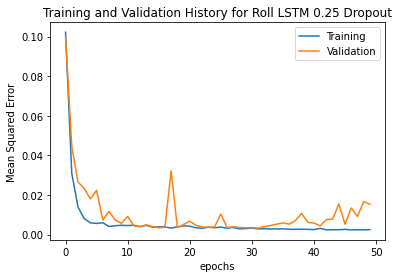

In [134]:
plt.plot(train_hist)
plt.plot(val_hist)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training and Validation History for Roll LSTM 0.25 Dropout")
plt.legend(['Training', 'Validation'])
plt.savefig('Pitch0.png')

In [23]:
#Enables dropout in evaluation mode
def enable_mc(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [24]:
with torch.no_grad():
  model.eval()
  enable_mc(model)
  model.refresh_cell()
  criterion = torch.nn.MSELoss(reduction='sum')

  losses = np.zeros(500)
  for j in range(500):
    totalLoss = 0
    for a in range(219):
        cool = model(torch.from_numpy(np.asarray(Xtest)[a]).float().to(device))
        loss = criterion(cool, torch.from_numpy(np.asarray(ytest)[a]).float().to(device))
        
        totalLoss += loss.item()
    losses[j] = totalLoss/219.0
  print(f'test loss: {np.mean(losses)} ± {np.std(losses)}')
 

test loss: 0.014400435885690902 ± 1.9183279468984937e-05


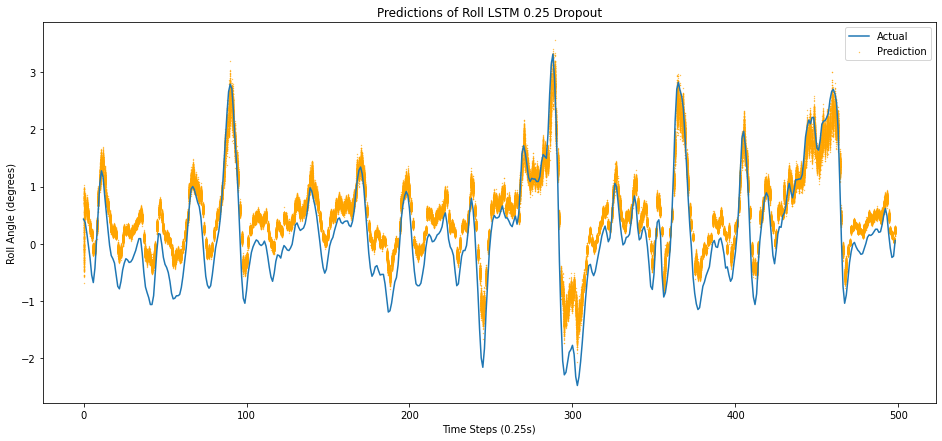

In [26]:
 plt.figure(figsize=(16,7))
for i in range(500):  
  a = 56
  cool = model(torch.from_numpy(np.asarray(Xtest)[a]).float().to(device))
  plt.scatter(np.asarray(range(499)), cool.detach().cpu().numpy()*90, s=0.1, c="orange")
plt.plot(ytest[a] * 90)
plt.xlabel("Time Steps (0.25s)")
plt.ylabel("Roll Angle (degrees)")
plt.legend(["Actual", "Prediction"])
plt.title("Predictions of Roll LSTM 0.25 Dropout")
plt.savefig("predictionroll25.png")